#### Chapter 8 in the 2nd edition, Chapter 9 in the 1st edition

##### 8.1*
The nonplanning method looks particularly poor in Figure 8.4 because
it is a one-step method; a method using multi-step bootstrapping would do better.
Do you think one of the multi-step bootstrapping methods from Chapter 7 could do
as well as the Dyna method? Explain why or why not.

The multi-step bootstrapping method could possibly do as well as the Dyna method with one-step updates, since both multi-step bootstrapping and Dyna algorithms assign values to all states previously visited in order to speed up learning. It's not clear to me which one would do better without an experiment.

##### 8.2

Why did the Dyna agent with exploration bonus, Dyna-Q+, perform
better in the first phase as well as in the second phase of the blocking and shortcut
experiments?


First phase: Dyna-Q+ performs better in the first phase than Dyna-Q because of the footnote description and since Dyna-Q+ explores more than Dyna-Q due to the augmented reward (thus more likely to find optimal path): 

> "The Dyna-Q+ agent was changed in two other ways as well. First, actions that had never been
tried before from a state were allowed to be considered in the planning step (f) of Figure 8.2. Second,
the initial model for such actions was that they would lead back to the same state with a reward of
zero."

Second phase: Dyna-Q+ performs better in the second phase since the new shorter path is learned under Dyna-Q+ but not under Dyna-Q. Dyna-Q+ augments the reward for unvisited states by $\kappa \sqrt{\tau}$, whereas during planning Dyna-Q discounts the value for unvisited states if they were not previously optimal. This forces Dyna-Q+ to keep exploring and eventually find the shorter path, while Dyna-Q has no reason to believe that a shorter path exists during planning.

##### 8.3 



Careful inspection of Figure 8.6 reveals that the difference between
Dyna-Q+ and Dyna-Q narrowed slightly over the first part of the experiment. What
is the reason for this?

I suspect that the narrowing in Figure 8.6 occurs since Dyna-Q learns episodes with $\epsilon$-greedy actions, and thus eventually finds the optimal path that Dyna-Q+ found a lot quicker due to Dyna-Q+ increased exploration.


##### 8.4

The exploration bonus described above actually
changes the estimated values of states and actions. Is this necessary? Suppose the
bonus κ√τ was used not in backups, but solely in action selection. That is, suppose
the action selected was always that for which Q(S, a) + $\kappa\sqrt{\tau_{S_a}}$ was maximal. Carry
out a gridworld experiment that tests and illustrates the strengths and weaknesses
of this alternate approach.

In [1]:
# Maze code obtained from 
# https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter08/VariousMaze.py
# Additional requirements from the problem statement were added to re-create Figure 8.6

# --------------------------------------------------------------------#
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Maze:

    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9
        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.oldObstacles = None
        self.newObstacles = None

        # time to change obstacles
        self.changingPoint = None

        # initial state action pair values
        self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # max steps
        self.maxSteps = float('inf')

        # track the resolution for this maze
        self.resolution = 1

    def takeAction(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

    


In [2]:

class PlanningModel(object):
    def __init__(self, environment, time_weight=0):
        self.time = 0
        self.model = dict()
        self.time_weight = time_weight
        self.environment = environment
        self.rand = np.random.RandomState(0)

    def save_experience(self, current_state, action, new_state, reward):
        """ Deterministic environment model
        """
        self.time += 1
        self.create_state_action_value(current_state, action)
        self.model[tuple(current_state)][action] = [list(new_state), reward, self.time]

    def sample(self):
        stateIndex = self.rand.choice(range(0, len(self.model.keys())))
        state = list(self.model.keys())[stateIndex]
        actionIndex = self.rand.choice(range(0, len(self.model[state].keys())))
        action = list(self.model[state].keys())[actionIndex]
        newState, reward, time = self.model[state][action]

        # adjust reward with elapsed time since last vist
        time_reward = self.time_weight * np.sqrt(self.time - time)

        return list(state), action, list(newState), reward, time_reward

    def get_time_reward(self, state, action):
        self.create_state_action_value(state, action=None)
        newState, reward, time = self.model[tuple(state)][action]
        return self.time_weight * np.sqrt(max(0, self.time - time))
    
    def create_state_action_value(self, current_state, action):
        if tuple(current_state) not in self.model:
            self.model[tuple(current_state)] = dict()

            # Actions that had never been tried before from a state 
            # were allowed to be considered in the planning step
            for action_ in self.environment.actions:
                if action_ != action:
                    # Such actions would lead back to the same state with a reward of zero
                    # Notice that the minimum time stamp is 1 instead of 0
                    self.model[tuple(current_state)][action_] = [list(current_state), 0, 1]
    

class DynaAgent(object):
    
    def __init__(self, gamma=0.95, epsilon=0.1, alpha=0.1, planning_steps=50):
        # discount factor
        self.gamma = gamma
        # probability for exploration
        self.epsilon = epsilon
        # step size
        self.alpha = alpha
        # planning steps
        self.planning_steps = planning_steps

    def epsilon_greedy_action(self, state, state_action_values, environment):
        if np.random.binomial(1, self.epsilon) == 1:
            return np.random.choice(environment.actions)
        return np.argmax(state_action_values[state[0], state[1], :])
    
    def epsilon_greedy_action_with_time_reward(self, state, state_action_values,
                                               environment, planning_model):
        if np.random.binomial(1, self.epsilon) == 1:
            return np.random.choice(environment.actions)
        Q = [planning_model.get_time_reward(state, a) for a in environment.actions]
        Q += state_action_values[state[0], state[1], :]
        return np.argmax(Q)

    def play_episode(self, state_action_values, planning_model,
                     environment, action_with_time_reward=False):
        steps = 0
        current_state = environment.START_STATE
        while current_state not in environment.GOAL_STATES:
            steps += 1

            if action_with_time_reward:
                action = self.epsilon_greedy_action_with_time_reward(
                    current_state, state_action_values, environment,
                    planning_model
                )
            else:
                action = self.epsilon_greedy_action(
                    current_state, state_action_values, environment
                )

            new_state, reward = environment.takeAction(current_state, action)

            # Q-Learning update
            state_action_values[current_state[0], current_state[1], action] += \
                self.alpha * (reward + self.gamma * np.max(
                        state_action_values[new_state[0], new_state[1], :]) -
                state_action_values[current_state[0], current_state[1], action])

            # feed the model with experience
            planning_model.save_experience(current_state, action, new_state, reward)

            # sample experience from the model
            for t in range(0, self.planning_steps):
                state_sample, action_sample, new_state_sample, reward_sample, time_reward = planning_model.sample()
                if not action_with_time_reward:
                    # only use the time_reward update if we don't select the actions 
                    # using the time rewards
                    reward_sample += time_reward
                state_action_values[state_sample[0], state_sample[1], action_sample] += \
                    self.alpha * (reward_sample + self.gamma * np.max(
                            state_action_values[new_state_sample[0], new_state_sample[1], :]) -
                    state_action_values[state_sample[0], state_sample[1], action_sample]) 

            current_state = new_state

            # check whether it has exceeded the step limit
            if steps > environment.maxSteps:
                break

        return steps



In [3]:

def changingMazeExperiment(environment, planning_model,
                           agent, num_runs=1, with_time_reward=False):
    """
    Runs an experiment given a changing environmnet, with a planning agent
    """

    # set up max steps
    maxSteps = environment.maxSteps

    # track the cumulative rewards
    # rewards = np.zeros((maxSteps))
    rewards_ = np.zeros((num_runs, maxSteps))

    for run in range(0, num_runs):
#         print('Run ', run)

        # initialize state action values
        stateActionValues = environment.stateActionValues

        # set old obstacles for the maze
        environment.obstacles = environment.oldObstacles

        steps = 0
        lastSteps = steps
        while steps < maxSteps:
            # play for an episode
            steps += agent.play_episode(
                stateActionValues, planning_model,
                environment, action_with_time_reward=with_time_reward
            )

            # update cumulative rewards
            steps_ = min(steps, maxSteps - 1)
            rewards_[run, lastSteps: steps_] = rewards_[run, lastSteps]
            rewards_[run, steps_] = rewards_[run, lastSteps] + 1
            lastSteps = steps

            if steps > environment.changingPoint:
                # change the obstacles
                environment.obstacles = environment.newObstacles

    # averaging over runs
    rewards = np.mean(rewards_, axis=0)

    return rewards



In [4]:
# set up a shortcut maze instance
shortcutMaze = Maze()
shortcutMaze.START_STATE = [5, 3]
shortcutMaze.GOAL_STATES = [[0, 8]]
shortcutMaze.oldObstacles = [[3, i] for i in range(1, 9)]

# new obstacles will have a shorter path
shortcutMaze.newObstacles = [[3, i] for i in range(1, 8)]

# step limit
shortcutMaze.maxSteps = 6000
shortcutMaze.changingPoint = 3000

In [5]:
# setup up the planning model and Agent
agent = DynaAgent(planning_steps=50, alpha=0.7)
agent2 = DynaAgent(planning_steps=0, alpha=0.7)
dynaq_model = PlanningModel(environment=shortcutMaze, time_weight=0)
dynaq_plus_model = PlanningModel(environment=shortcutMaze, time_weight=5e-4)


In [6]:
# run experiments
dynaq_rewards = changingMazeExperiment(
    shortcutMaze, planning_model=dynaq_model, agent=agent, num_runs=2
)
dynaq_plus_rewards = changingMazeExperiment(
    shortcutMaze, planning_model=dynaq_plus_model, agent=agent, num_runs=2
)
dynaq_plus_84_rewards = changingMazeExperiment(
    shortcutMaze, planning_model=dynaq_plus_model,
    agent=agent2, num_runs=2, with_time_reward=True
)

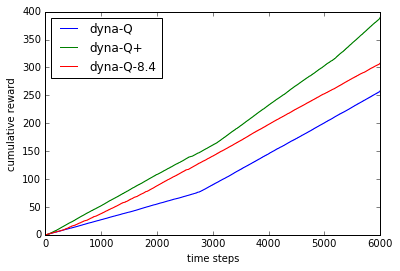

In [7]:
plt.plot(dynaq_rewards, label='dyna-Q')
plt.plot(dynaq_plus_rewards, label='dyna-Q+')
plt.plot(dynaq_plus_84_rewards, label='dyna-Q-8.4')

plt.xlabel('time steps')
plt.ylabel('cumulative reward')
plt.legend(loc='best')

For the short-cut maze problem, we see that the 8.4 method (using $\kappa \sqrt{\tau}$ for action selection only and not for planning) results in similar performance as dyna-Q if the number of planning steps is large (as the planning steps are identical). If the number of planning steps is close to 0, the 8.4 method does better than dyna-Q because of the exploration step in the action selection. Overall, the 8.4 method in the problem doesn't seem to add much value to dyna-Q, since the action selection is not as exploratory as dyna-Q+ for the maze shortcut.

##### 9.5

The analysis above assumed that all of the  possible next states were equally likely to occur. Suppose instead that the distribution was highly skewed, that some of the  states were much more likely to occur than most. Would this strengthen or weaken the case for sample backups over full backups? Support your answer.

If the distribution of next states was highly skewed, full backups would be better on states more likely to occur rather than sample backups on several states, some of which were unlikely to occur.

##### 9.6**


Some of the graphs in Figure 9.14 seem to be scalloped in their early portions, particularly the upper graph for $b=1$  and the uniform distribution. Why do you think this is? What aspects of the data shown support your hypothesis?


I'm not sure at all why this is happening and wasn't able to reproduce it for some reason. 

##### 9.7 

If you have access to a moderately large computer, try replicating the experiment whose results are shown in the lower part of Figure  9.14. Then try the same experiment but with b=3. Discuss the meaning of your results.


In [8]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [9]:

class TrajectorySampling(object):
    def __init__(self, n=0, k=0, gamma=0.9, alpha=0.1,
                 epsilon=0.1, max_num_tasks=2000):
        """
        Args:
            n (int): Number of states
            k (int): Branching factor for each state
            gamma (float): discount factor
            epsilon (float): probability of choosing a non-greedy action
            alpha (float): probability of landing in terminal state
        """
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.max_num_tasks = max_num_tasks

    def setup(self, n_arg, k_arg):
        """ Setup the reward, Q-value, and policy arrays
        """
        self.n = n_arg
        self.k = k_arg
        self.successor = np.zeros((self.n, 2, self.k)).astype(int)
        self.R = np.zeros((self.n, self.k + 1, 2))
        self.Q = np.zeros((self.n, 2))
        self.policy = np.zeros((self.n)).astype(int)
        self.V = np.zeros((self.n))
        self.randomness = np.zeros((self.max_num_tasks)).astype(int)
        for t in range(self.max_num_tasks):
            self.randomness[t] = np.random.randint(low=0, high=self.max_num_tasks * 9999)

    def init(self, task_num):
        """ Initialize the Q, R, and successor array. The successor array determines
            the next state given an action in a given state
        """
        np.random.seed(seed=self.randomness[task_num])
        self.Q = np.zeros_like(self.Q)
        self.R = np.random.rand(*self.R.shape)
        for s in range(self.n):
            for a in range(2):
                for i, sp in enumerate(np.random.choice(self.n, self.k)):
                    self.successor[s, a, i] = sp

    def next_state(self, s, a):
        if np.random.rand() > self.alpha:
            k = np.random.randint(0, high=self.k)
            return self.successor[s, a, k]
        return self.n

    def full_backup(self, s, a):
        backup = 0
        for i in range(self.k):
            sp = self.successor[s, a, i]
            backup += self.R[s, i, a] + self.gamma * np.max(self.Q[sp, :])
        backup = backup * (1 - self.alpha) / self.k + self.alpha * self.R[s, self.k, a]
        return backup

    def run_sweeps(self, n_arg, k_arg, num_runs, num_sweeps, sweeps_per_measurement):
        self.setup(n_arg, k_arg)
        backups_per_measurement = (sweeps_per_measurement * 2 * self.n)
        backups_per_sweep = self.n * 2
        num_backups = num_sweeps * backups_per_sweep
        num_measurements = num_backups // backups_per_measurement
        perf = np.zeros((num_runs, num_measurements))
        for run in range(num_runs):
            self.init(run)
            backups = 0
            for ns in range(num_sweeps):
                for s in range(self.n):
                    for a in range(2):
                        if backups % backups_per_measurement == 0:
                            perf[run, backups // backups_per_measurement] = self.measure_performance()
                        self.Q[s, a] = self.full_backup(s, a)
                        backups += 1
        return perf
        
    def run_trajectories(self, n_arg, k_arg, num_runs, num_sweeps, sweeps_per_measurement):
        self.setup(n_arg, k_arg)
        backups_per_measurement = (sweeps_per_measurement * 2 * self.n)
        backups_per_sweep = self.n * 2
        num_backups = num_sweeps * backups_per_sweep
        num_measurements = num_backups // backups_per_measurement
        perf = np.zeros((num_runs, num_measurements))
        for run in range(num_runs):
            self.init(run)
            backups = 0
            state = 0 
            while state != self.n:
                action = np.random.choice(2) if np.random.rand() < self.epsilon\
                    else np.argmax(self.Q[state, :])
                nxt_state = self.next_state(state, action)
                if backups % backups_per_measurement == 0:
                    perf[run, backups // backups_per_measurement] += self.measure_performance()
                self.Q[state, action] = self.full_backup(state, action)
                backups += 1

                if backups == num_backups:
                    break

                state = nxt_state
                if state == self.n:
                    state = 0

        return perf

    def measure_performance(self):
        for s in range(self.n):
            self.V[s] = 0.0
            self.policy[s] = np.argmax(self.Q[s, :])

        delta = 1
        while delta > 0.001:
            delta = 0
            for s in range(self.n):
                old_V = self.V[s]
                self.V[s] = self.full_backup(s, self.policy[s])
                delta += np.sum(np.abs(old_V - self.V[s]))
        return self.V[0]
            

In [10]:
ts = TrajectorySampling()

In [11]:

sweep_results = ts.run_sweeps(
    n_arg=1000, k_arg=1, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

trajectory_results = ts.run_trajectories(
    n_arg=1000, k_arg=1, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

sweep_results3 = ts.run_sweeps(
    n_arg=1000, k_arg=3, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

trajectory_results3 = ts.run_trajectories(
    n_arg=1000, k_arg=3, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)



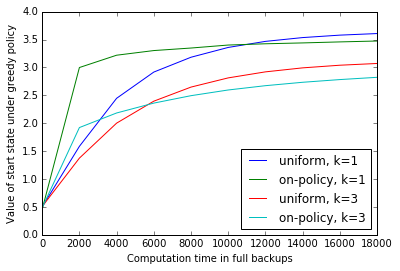

In [12]:
x = (np.ones(sweep_results.shape[1]).cumsum() - 1) * ts.n * 2

plt.plot(x, np.mean(sweep_results, axis=0))
plt.plot(x, np.mean(trajectory_results, axis=0))

plt.plot(x, np.mean(sweep_results3, axis=0))
plt.plot(x, np.mean(trajectory_results3, axis=0))

plt.xlabel('Computation time in full backups')
plt.ylabel('Value of start state under greedy policy')

plt.legend(['uniform, k=1', 'on-policy, k=1', 'uniform, k=3', 'on-policy, k=3'], loc='best')

In [15]:

sweep_results = ts.run_sweeps(
    n_arg=10000, k_arg=1, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

trajectory_results = ts.run_trajectories(
    n_arg=10000, k_arg=1, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

sweep_results3 = ts.run_sweeps(
    n_arg=10000, k_arg=3, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)

trajectory_results3 = ts.run_trajectories(
    n_arg=10000, k_arg=3, num_runs=200,
    num_sweeps=10, sweeps_per_measurement=1
)


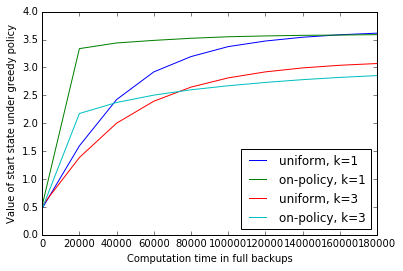

In [16]:
x = (np.ones(sweep_results.shape[1]).cumsum() - 1) * ts.n * 2

plt.plot(x, np.mean(sweep_results, axis=0))
plt.plot(x, np.mean(trajectory_results, axis=0))

plt.plot(x, np.mean(sweep_results3, axis=0))
plt.plot(x, np.mean(trajectory_results3, axis=0))

plt.xlabel('Computation time in full backups')
plt.ylabel('Value of start state under greedy policy')

plt.legend(['uniform, k=1', 'on-policy, k=1', 'uniform, k=3', 'on-policy, k=3'], loc='best')

We see that the results for 10k states are similar to those with 1k states, where the k=3 branching factor has a similar effect on the value funtion as before.